In [1]:
import os, pickle
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from utils import generate_embedding, MLP, train, validate

/home/gserra/miniconda3/envs/fcl-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data preparation

In [ ]:
dir_output = f'./data/nlp/newsgrops'
fn_emb_tr = f'{dir_output}/embeddings_train.pkl'
fn_emb_val = f'{dir_output}/embeddings_val.pkl'
fn_emb_te = f'{dir_output}/embeddings_test.pkl'
fn_lab_tr = f'{dir_output}/labels_train.pkl'
fn_lab_val = f'{dir_output}/labels_val.pkl'
fn_lab_te = f'{dir_output}/labels_test.pkl'

if not os.path.exists(fn_emb_tr):
    os.makedirs(dir_output)
    newsgroups_train = fetch_20newsgroups(subset='train')
    newsgroups_test = fetch_20newsgroups(subset='test')

    # Create train/validation split
    input_train_full = ['query: ' + news for news in newsgroups_train.data]
    y_train_full = torch.tensor(newsgroups_train.target, dtype=torch.int64)

    input_train, input_val, y_train, y_val = train_test_split(
        input_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full)

    input_test = ['query: ' + news for news in newsgroups_test.data]
    y_test = torch.stack([torch.tensor(label, dtype=torch.int64) for label in newsgroups_test.target])

    embeddings_tr = generate_embedding(input_train)
    embeddings_val = generate_embedding(input_val)
    embeddings_te = generate_embedding(input_test)

    # normalize embeddings
    embeddings_tr = F.normalize(embeddings_tr, p=2, dim=1)
    embeddings_val = F.normalize(embeddings_val, p=2, dim=1)
    embeddings_te = F.normalize(embeddings_te, p=2, dim=1)
    # dimensionality check
    print('train:', embeddings_tr.shape, y_train.shape)
    print('val:', embeddings_val.shape, y_val.shape)
    print('test:', embeddings_te.shape, y_test.shape)

    # Save generated output
    with open(fn_emb_tr, 'wb') as outfile:
        pickle.dump(embeddings_tr, outfile)
        outfile.close()
    with open(fn_emb_val, 'wb') as outfile:
        pickle.dump(embeddings_val, outfile)
        outfile.close()
    with open(fn_emb_te, 'wb') as outfile:
        pickle.dump(embeddings_te, outfile)
        outfile.close()
    with open(fn_lab_tr, 'wb') as outfile:
        pickle.dump(y_train, outfile)
        outfile.close()
    with open(fn_lab_val, 'wb') as outfile:
        pickle.dump(y_val, outfile)
        outfile.close()
    with open(fn_lab_te, 'wb') as outfile:
        pickle.dump(y_test, outfile)
        outfile.close()

else:
    embeddings_tr = pickle.load(open(fn_emb_tr, 'rb'))
    embeddings_val = pickle.load(open(fn_emb_val, 'rb'))
    embeddings_te = pickle.load(open(fn_emb_te, 'rb'))
    y_train = pickle.load(open(fn_lab_tr, 'rb'))
    y_val = pickle.load(open(fn_lab_val, 'rb'))
    y_test = pickle.load(open(fn_lab_te, 'rb'))

# Define data loaders
ds_train = torch.utils.data.TensorDataset(embeddings_tr, y_train)
ds_val = torch.utils.data.TensorDataset(embeddings_val, y_val)
ds_test = torch.utils.data.TensorDataset(embeddings_te, y_test)
train_loader = DataLoader(ds_train, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(ds_val, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(ds_test, batch_size=64, shuffle=False, num_workers=2)

### Model initialization

In [3]:
# for reproducibility purposes
np.random.seed(19)
torch.manual_seed(19)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

input_size = embeddings_tr.shape[1]
num_classes = len(set(y_train.numpy()))

model = MLP(input_size, [512], num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

### Model training

In [4]:
epochs = 100
best_val_accuracy = 0
patience = 20
patience_epoch = 0

for epoch in range(epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, val_loader, criterion, device)
    
    print(f"Epoch [{epoch+1}/{epochs}], "
          f"Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"Val Accuracy: {val_accuracy:.4f}")
    
    # Save the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), './checkpoint/best_mlp.pth')  # create folder './checkpoint/' before running this cell
        patience_epoch = 0
    else:
        patience_epoch += 1
        if patience_epoch >= patience:
            break


Epoch [1/100], Train Loss: 2.6904, Val Loss: 2.1288, Val Accuracy: 0.5356
Epoch [2/100], Train Loss: 1.6932, Val Loss: 1.3524, Val Accuracy: 0.6350
Epoch [3/100], Train Loss: 1.1472, Val Loss: 1.0082, Val Accuracy: 0.7181
Epoch [4/100], Train Loss: 0.9018, Val Loss: 0.8477, Val Accuracy: 0.7795
Epoch [5/100], Train Loss: 0.7646, Val Loss: 0.7502, Val Accuracy: 0.7888
Epoch [6/100], Train Loss: 0.6720, Val Loss: 0.6898, Val Accuracy: 0.8126
Epoch [7/100], Train Loss: 0.6037, Val Loss: 0.6414, Val Accuracy: 0.8193
Epoch [8/100], Train Loss: 0.5612, Val Loss: 0.6117, Val Accuracy: 0.8255
Epoch [9/100], Train Loss: 0.5211, Val Loss: 0.5942, Val Accuracy: 0.8215
Epoch [10/100], Train Loss: 0.4958, Val Loss: 0.5676, Val Accuracy: 0.8347
Epoch [11/100], Train Loss: 0.4712, Val Loss: 0.5505, Val Accuracy: 0.8347
Epoch [12/100], Train Loss: 0.4516, Val Loss: 0.5625, Val Accuracy: 0.8268
Epoch [13/100], Train Loss: 0.4349, Val Loss: 0.5435, Val Accuracy: 0.8369
Epoch [14/100], Train Loss: 0.4193

### Model evaluation

In [5]:
test_loss, test_accuracy = validate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.6592, Test Accuracy: 0.7926


### Extract most uncertaint points given the trained model and a dataloader (usually, test set)

- `dataloader`: loader of the data points we want to inspect
- `model`: trained model to use for evaluating the points in the dataloader
- `num_points`: number of points we want to extract
- `order`: `top-k` (most uncertain points), `bottom-k` (most certain points)

In [6]:
from uncertainty_module import get_uncertainty
unc_scores, score_idx = get_uncertainty(dataloader=test_loader, model=model, num_points=10, order='top-k', device=device)

100%|██████████| 118/118 [00:00<00:00, 191.72it/s]


In [7]:
from utils import get_client_features, plot_client_features
embeddings_2d, labels = get_client_features(test_loader, model, device)

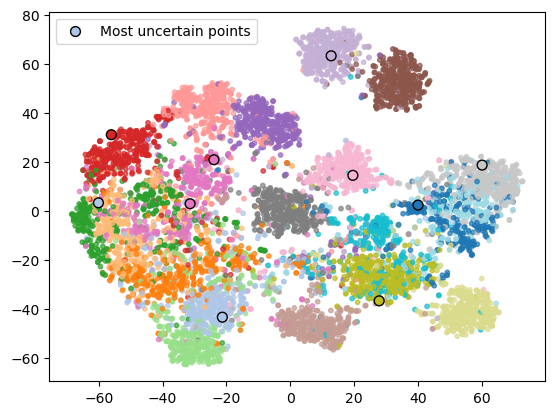

In [8]:
plot_client_features(embeddings_2d, labels, score_idx, n_classes=20)